<a href="https://colab.research.google.com/github/dina-lab3D/CombFold/blob/master/CombFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

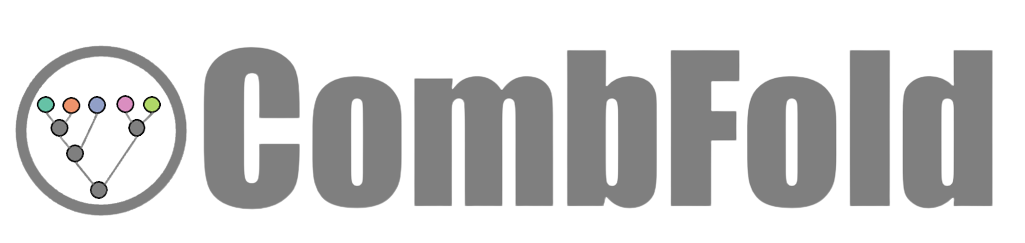


This notebook runs the CombFold assembly algorithm. The algorithm assembles large protein complexes, by combining PDB files of possible subcomplexes. "Possible subcomplexes" are structure models of different combinations of subunits from the target complex.

By default, the notebook runs on an example ([PDB: 6YBQ](https://www.rcsb.org/structure/6YBQ)), but by uploading your own PDB files to Google Drive (and creating a subunits.json) you can assemble your complex by changing the path in the "Run" cell, as instructed in the cell.


**The inputs** are 
1. subunits.json - a json describing all the subunits (sequences) in the complex.
2. pdbs folder - a folder with AlphaFold-Multimer models (PDB files) of different combinations of these subunits.

**The output** consists of  several .PDB files which are models of the assembled complex structure.
more information is available on https://github.com/dina-lab3D/CombFold.


In [ ]:
#@title Install CombFold (~2 min)

!pip -q install biopython
!pip -q install py3Dmol
!echo Installed python dependencies

!wget -qnc -O CombFold-master.zip wget https://github.com/dina-lab3D/CombFold/archive/refs/heads/master.zip
!unzip -q CombFold-master.zip
!echo Downloaded CombFold, Installing
!cd CombFold-master/CombinatorialAssembler && make --silent
!echo CombFold Installed!

import py3Dmol
import os

def view_pdb_color_by_chain(pdb_path: str):
  pdb_content = open(pdb_path, "r").read()
  view = py3Dmol.view(width=400, height=300)
  view.addModelsAsFrames(pdb_content)

  # Get the list of chains in the protein
  chains = {i[21] for i in pdb_content.split("\n") if len(i) > 21}

  # Assign a color to each chain
  colors = ["red", "blue", "green", "orange", "purple", "yellow", "pink", "brown", "black", "gray", "cyan", "magenta", "olive", "maroon", "navy", "teal", "gold", "silver", "crimson"]
  colors = 10 * colors

  # Set the style for each chain
  for i, chain in enumerate(chains):
      view.setStyle({'chain': chain}, {'cartoon': {'color': colors[i]}})

  view.zoomTo()
  view.show()


In [ ]:
#@title View example elements  {run: "auto"}

#@markdown  Here we demonstrate the input used to create a model of [PDB: 6YBQ](https://www.rcsb.org/structure/6YBQ). This complex have a total of 12 chains, composed of 2 subunits (unique chains in this case) with 6 copies each. 

#@markdown  - subunits.json - Defines two subunits (A0 and G0) with 6 copies each (implemented by defining 6 chain_names)

#@markdown  - pdb files - Structure models predicted by AlphaFold-Multimer of different subsets of 2 or 3 subunits from the complex. Each combination have multiple models, as many different pairwise interactions can be considered during assembly

#@markdown  You can view elements in the input by choosing them and running the cell.

element_to_view = 'subunits.json' #@param ["subunits.json", 'pdbs/AFM_A0_A0_unrelaxed_rank_1_model_1.pdb', 'pdbs/AFM_A0_A0_unrelaxed_rank_2_model_4.pdb', 'pdbs/AFM_A0_G0_unrelaxed_rank_1_model_2.pdb', 'pdbs/AFM_A0_G0_unrelaxed_rank_2_model_3.pdb', 'pdbs/AFM_G0_G0_unrelaxed_rank_2_model_5.pdb', 'pdbs/AFM_G0_G0_unrelaxed_rank_1_model_4.pdb', 'pdbs/AFM_A0_A0_A0_unrelaxed_rank_1_model_3.pdb', 'pdbs/AFM_A0_A0_A0_unrelaxed_rank_2_model_1.pdb','pdbs/AFM_A0_A0_G0_unrelaxed_rank_2_model_3.pdb', 'pdbs/AFM_A0_A0_G0_unrelaxed_rank_1_model_1.pdb']
example_path = "/content/CombFold-master/example/"

subunits_path = os.path.join(example_path, "subunits.json")

if element_to_view == 'subunits.json':
  print(open(subunits_path, "r").read())
else:
  view_pdb_color_by_chain(os.path.join(example_path, element_to_view))


In [ ]:
#@title Run (~2 min on example)
import os
#@markdown The folder path on drive should have 
#@markdown (1) a file named "subunits.json" with a description of the subunits 
#@markdown and (2) a folder in it named "pdbs" containing all pdbs created by AFM. 

#@markdown  The results will be saved to a new folder named "assembled", under the path_on_drive .

#@markdown The path should start with /content/drive/MyDrive/ and can be copied by selecting it from the files sidebar with Right-Click->Copy Path.
path_on_drive = '/content/CombFold-master/example/' #@param {type:"string"}
max_results_number = "5" #@param [1, 5, 10, 20]
create_cif_instead_of_pdb = False #@param {type:"boolean"}

subunits_path = os.path.join(path_on_drive, "subunits.json")
pdbs_folder = os.path.join(path_on_drive, "pdbs")
assembled_folder = os.path.join(path_on_drive, "assembled")
tmp_assembled_folder = "/content/tmp_assembled"

if os.path.exists(assembled_folder):
  answer = input(f"{assembled_folder} already exists, Should delete? (y/n)")
  if answer in ("y", "Y"):
    print("Deleteing")
    shutil.rmtree(assembled_folder)
  else:
    print("Stopping")
    exit()
  
if os.path.exists(tmp_assembled_folder):
  shutil.rmtree(tmp_assembled_folder)

import subprocess
import sys
import shutil
sys.path.append("/content/CombFold-master/scripts/")
import run_on_pdbs
run_on_pdbs.run_on_pdbs_folder(subunits_path, pdbs_folder, tmp_assembled_folder,
                               output_cif=create_cif_instead_of_pdb,
                               max_results_number=int(max_results_number))

shutil.copytree(os.path.join(tmp_assembled_folder, "assembled_results"),
                assembled_folder)

print("Results saved to", assembled_folder)

In [ ]:
#@title Display Assemled 3D structure models {run: "auto"}
model_num = "0" #@param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
model_num = int(model_num)

output_filenames = [i for i in os.listdir(assembled_folder) if i.endswith(".pdb") or i.endswith(".cif")]
assert model_num < len(output_filenames), f"Only have {len(output_filenames)} models"
output_path = os.path.join(assembled_folder, output_filenames[model_num])

view_pdb_color_by_chain(output_path)
